# REBOUND Functionality

This notebook contains an example from REBOUND started from a SERPENS simulation by simply passing `init_serpens=False` to `SerpensSimulation`.
This [example](https://github.com/hannorein/rebound/blob/main/ipython_examples/Churyumov-Gerasimenko.ipynb) is all about the orbit of 67P/Churyumov–Gerasimenko.

It teaches you how to use the IAS15 integrator (Rein and Spiegel, 2015) to simulate the orbit of 67P/Churyumov–Gerasimenko. We will download the data from NASA Horizons and visualize the orbit using matplotlib.


## NASA Horizons

If you're interested in Solar System dynamics, you have probably heard of NASA Horizons. It's a large database of Solar System objects, their orbits and physical properties. It includes planets, moons, satellites, asteroids, comets and spacecrafts. With REBOUND, you can easily import data from NASA Horizons. As an example, let's pull in the present day positions of Jupiter, Saturn and the Sun:

In [1]:
from serpens_simulation import SerpensSimulation

sim = SerpensSimulation(init_serpens=False)
sim.add("Sun")
sim.add("Jupiter")
sim.add("Saturn")

Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'Jupiter'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')
Searching NASA Horizons for 'Saturn'... 
Found: Saturn Barycenter (6) (chosen from query 'Saturn')


Now all the data is in REBOUND! Let's have a look at the orbits of the two planets.

In [2]:
for orbit in sim.orbits():
    print(orbit)

<rebound.Orbit instance, a=5.202227567674912 e=0.048283449855485314 inc=0.022751845102281804 Omega=1.7543641415717641 omega=4.772947624644667 f=0.7638680092318086>
<rebound.Orbit instance, a=9.545897037691851 e=0.05465218041394654 inc=0.04341483178743914 Omega=1.9826368904972873 omega=5.903085643180979 f=4.365629635851777>


Although there are three bodies, the `orbits()` function only returns two objects as the orbit for the Sun would be a little boring. The function returns the orbits in Jacobi coordinates. Since we didn't specify a value for $G$, REBOUND assumes that $G=1$. The unit of length is one astronomical unit, the unit of time is one year/$2\pi$.

Let's add something more interesting to our simulation: the comet 67P/Churyumov-Gerasimenko.

In [3]:
sim.add("Churyumov-Gerasimenko")

Searching NASA Horizons for 'Churyumov-Gerasimenko'... 
Found: 67P/Churyumov-Gerasimenko (chosen from query 'Churyumov-Gerasimenko')


When searching for a body by name, REBOUND takes the first dataset that Horizons offers. In this case, it's a set of parameters from 1962. You probably want to go to the Horizons website and check that the values you are using are up-to-date and appropriate for what you want to do. You can also use more complicated Horizons queries, for example, to get the most recent apparition solution for the comet, use

`sim.add("NAME=Churyumov-Gerasimenko; CAP")`

You can also use the IAU asteroid number for numbered asteroids, or the database record numbers from Horizons for objects not yet numbered by the IAU (but note that database record numbers can change as the database gets rearranged with new discoveries, see https://ssd.jpl.nasa.gov/?horizons_doc#sb for details). In our case the current database record number is 900647, so you could use sim.add("900647") to get the newest set of orbital parameters for Churyumov-Gerasimenko.

NASA Horizons doesn't have masses for all bodies. If REBOUND doesn't find a mass, you get a warning message (see above). In our case, we don't need the mass of the comet (it's really small). However, it you want, you can add it manually using the syntax `sim.add("Churyumov-Gerasimenko", m=5.03e-18).

Before we integrate the orbits, let's plot the instantaneous orbits using the built-in REBOUND class `OrbitPlot`.

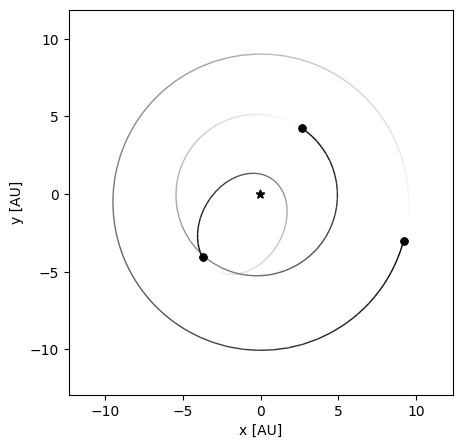

In [4]:
import rebound
fig = rebound.OrbitPlot(sim, unitlabel="[AU]")

## Integration with IAS15

We will integrate backwards in time for 70 years. Because we don't know what will happen yet (hint: a close encounter) we will use the IAS15 integrator. It is fast, accurate and has adaptive timesteps to capture any potential close encounters.

To integrate backwards, we could set a negative timestep or multiply all velocities with $-1$. We'll choose the first option:

In [5]:
sim.dt = -0.01

While we're integrating, let's store the positions of Jupiter and the comet at 10000 times during the interval. We'll need to prepare a few variables to do that:

In [6]:
import numpy as np
Noutputs = 10000
year = 2.*np.pi # One year in units where G=1
times = np.linspace(0.,-70.*year, Noutputs)
x = np.zeros((2,Noutputs))
y = np.zeros((2,Noutputs))
z = np.zeros((2,Noutputs))

Now we're ready to start the integration:

In [7]:
sim.integrator = "ias15" # IAS15 is the default integrator, so we actually don't need this line
sim.move_to_com()        # We always move to the center of momentum frame before an integration
ps = sim.particles       # ps is now an array of pointers and will change as the simulation runs

for i,time in enumerate(times):
    sim.integrate(time)
    x[0][i] = ps[1].x   # This stores the data which allows us to plot it later
    y[0][i] = ps[1].y
    z[0][i] = ps[1].z
    x[1][i] = ps[3].x
    y[1][i] = ps[3].y
    z[1][i] = ps[3].z

10000it [00:00, 43526.35it/s]


## Visualization with matplotlib

Let's plot the orbits of Jupiter (blue) and the comet (green) to get an idea of what was going on during our integration.

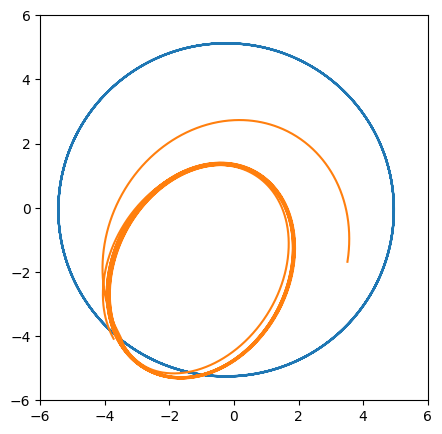

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
ax.set_xlim([-6,6])
ax.set_ylim([-6,6])
plt.plot(x[0], y[0]);
plt.plot(x[1], y[1]);